In [1]:
# 动作识别系统 - NTU RGB+D 子集 (仅训练+评估精简版)
# 使用步骤 (现已自动化): 直接 运行全部 即可开始训练并保存结果。
# 自动输出: 1) 训练曲线 PNG -> RESULT_DIR  2) 分类报告 TXT -> REPORT_DIR  3) 模型/映射/Scaler/LabelEncoder

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import os
import pickle
import json
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 输出目录配置（若不存在会自动创建）
RESULT_DIR = r"F:/DataSet/Raw_Skeleton_S01-S17/result"   # 训练曲线保存目录
REPORT_DIR = r"F:/DataSet/Raw_Skeleton_S01-S17/report"   # 分类报告保存目录
os.makedirs(RESULT_DIR, exist_ok=True)
os.makedirs(REPORT_DIR, exist_ok=True)

print("环境初始化完成 - TensorFlow:", tf.__version__)
print("结果目录:", RESULT_DIR)
print("报告目录:", REPORT_DIR)

环境初始化完成 - TensorFlow: 2.20.0
结果目录: F:/DataSet/Raw_Skeleton_S01-S17/result
报告目录: F:/DataSet/Raw_Skeleton_S01-S17/report


In [2]:
# 数据集路径设置（如需修改请直接改这里）
DATA_PATHS = [
    r"F:/DataSet/Raw_Skeleton_S01-S17/skeleton+D0-30000",
    r"F:/DataSet/Raw_Skeleton_S01-S17/skeleton+D30001-56880"
 ]
print("DATA_PATHS 已设置:", DATA_PATHS)

DATA_PATHS 已设置: ['F:/DataSet/Raw_Skeleton_S01-S17/skeleton+D0-30000', 'F:/DataSet/Raw_Skeleton_S01-S17/skeleton+D30001-56880']


In [3]:
# ==== 训练超参数配置 (可修改) ====
TRAIN_EPOCHS = 50           # 训练轮数
TRAIN_BATCH_SIZE = 32       # 批次大小
TRAIN_LR = 0.00025           # 学习率
TRAIN_OPTIMIZER = 'adam'    # 'adam' | 'sgd' | 'rmsprop'
USE_OPTIMIZED_MODEL = True  # 是否使用 Conv1D + BiLSTM
AUTO_RUN_AFTER_DEFINE = True  # 若为 True, 所有定义完成后自动开始训练

print(f"配置: epochs={TRAIN_EPOCHS}, batch_size={TRAIN_BATCH_SIZE}, lr={TRAIN_LR}, optimizer={TRAIN_OPTIMIZER}, optimized={USE_OPTIMIZED_MODEL}, autorun={AUTO_RUN_AFTER_DEFINE}")

配置: epochs=50, batch_size=32, lr=0.00025, optimizer=adam, optimized=True, autorun=True


In [4]:
# ==== 动作名称映射与训练子集配置 ====
# 仅使用指定的 22 个动作 (用户需求)
SELECTED_ACTIONS = [1,2,8,9,14,15,16,17,28,29,30,41,42,43,44,45,46,47,48,49,59,60]

# 只列出当前需要用到的动作名称（可扩展）
ACTION_NAME_MAP = {
    1: "drink water", 2: "eat meal/snack", 3: "brushing teeth", 4: "brushing hair",
    5: "drop", 6: "pickup", 7: "throw", 8: "sitting down", 9: "standing up", 10: "clapping",
    11: "reading", 12: "writing", 13: "tear up paper", 14: "wear jacket", 15: "take off jacket",
    16: "wear a shoe", 17: "take off a shoe", 18: "wear on glasses", 19: "take off glasses", 20: "put on a hat/cap",
    21: "take off a hat/cap", 22: "cheer up", 23: "hand waving", 24: "kicking something", 25: "reach into pocket",
    26: "hopping", 27: "jump up", 28: "phone call", 29: "play with phone/tablet", 30: "type on a keyboard",
    41: "sneeze/cough", 42: "staggering", 43: "falling down", 44: "headache", 45: "chest pain",
    46: "back pain", 47: "neck pain", 48: "nausea/vomiting", 49: "fan self",
    59: "walking towards", 60: "walking apart"
}

print("将仅训练以下动作类别 (共", len(SELECTED_ACTIONS), "个):")
print(SELECTED_ACTIONS)


将仅训练以下动作类别 (共 22 个):
[1, 2, 8, 9, 14, 15, 16, 17, 28, 29, 30, 41, 42, 43, 44, 45, 46, 47, 48, 49, 59, 60]


In [5]:
# 1. NTU RGB+D 数据集处理类
class NTUDataProcessor:
    def __init__(self, data_path):
        self.data_path = data_path
        self.actions = {}  # 动作标签映射
        self.sequences = []  # 骨骼序列数据
        self.labels = []     # 对应标签
        
        # NTU RGB+D 25个关节点定义
        self.ntu_joints = {
            0: 'spine_base', 1: 'spine_mid', 2: 'neck', 3: 'head',
            4: 'shoulder_left', 5: 'elbow_left', 6: 'wrist_left', 7: 'hand_left',
            8: 'shoulder_right', 9: 'elbow_right', 10: 'wrist_right', 11: 'hand_right',
            12: 'hip_left', 13: 'knee_left', 14: 'ankle_left', 15: 'foot_left',
            16: 'hip_right', 17: 'knee_right', 18: 'ankle_right', 19: 'foot_right',
            20: 'spine_shoulder', 21: 'hand_tip_left', 22: 'thumb_left',
            23: 'hand_tip_right', 24: 'thumb_right'
        }
    
    def parse_skeleton_file(self, file_path):
        """解析NTU RGB+D的skeleton文件"""
        with open(file_path, 'r') as f:
            frame_count = int(f.readline())
            sequence = []
            
            for frame in range(frame_count):
                body_count = int(f.readline())
                frame_data = []
                
                for body in range(body_count):
                    # 读取body info
                    body_info = f.readline()
                    joint_count = int(f.readline())
                    
                    joints = []
                    for joint in range(joint_count):
                        joint_data = list(map(float, f.readline().split()))
                        # joint_data: [x, y, z, depth_x, depth_y, color_x, color_y, orient_w, orient_x, orient_y, orient_z, tracking_state]
                        # 我们主要使用前3个坐标: x, y, z
                        joints.append([joint_data[0], joint_data[1], joint_data[2]])
                    
                    if len(joints) == 25:  # 确保有25个关节点
                        frame_data.append(joints)
                
                if frame_data:  # 如果有有效的body数据
                    sequence.append(frame_data[0])  # 取第一个人的数据
            
            return np.array(sequence) if sequence else None
    
    def extract_action_label(self, filename):
        """从文件名提取动作标签"""
        # NTU文件名格式: SsssCcccPpppRrrrAaaa.skeleton
        # A后面的三位数字是动作编号
        action_id = int(filename[17:20])
        return action_id
    
    def load_dataset(self, max_files=None):
        """加载数据集"""
        skeleton_files = [f for f in os.listdir(self.data_path) if f.endswith('.skeleton')]
        
        if max_files:
            skeleton_files = skeleton_files[:max_files]
        
        print(f"找到 {len(skeleton_files)} 个skeleton文件")
        
        for i, filename in enumerate(skeleton_files):
            file_path = os.path.join(self.data_path, filename)
            sequence = self.parse_skeleton_file(file_path)
            
            if sequence is not None and len(sequence) > 0:
                action_label = self.extract_action_label(filename)
                self.sequences.append(sequence)
                self.labels.append(action_label)
            
            if (i + 1) % 100 == 0:
                print(f"已处理 {i + 1} 个文件...")
        
        print(f"成功加载 {len(self.sequences)} 个序列")
        return np.array(self.sequences, dtype=object), np.array(self.labels)

# 初始化数据处理器
# data_processor = NTUDataProcessor("你的NTU数据集路径")
print("NTU数据处理类定义完成!")

NTU数据处理类定义完成!


In [6]:
# 2. NTU到MediaPipe关节点映射
class JointMapper:
    def __init__(self):
        # NTU RGB+D (25关节) 到 MediaPipe Pose (33关节) 的映射
        self.ntu_to_mediapipe = {
            # 头部和颈部
            3: 0,   # head -> nose
            2: 11,  # neck -> left_shoulder (近似)
            2: 12,  # neck -> right_shoulder (近似)
            
            # 上半身
            20: 11, # spine_shoulder -> left_shoulder (近似)
            20: 12, # spine_shoulder -> right_shoulder (近似)
            4: 11,  # shoulder_left -> left_shoulder
            8: 12,  # shoulder_right -> right_shoulder
            5: 13,  # elbow_left -> left_elbow
            9: 14,  # elbow_right -> right_elbow
            6: 15,  # wrist_left -> left_wrist
            10: 16, # wrist_right -> right_wrist
            7: 17,  # hand_left -> left_pinky (近似)
            11: 18, # hand_right -> right_pinky (近似)
            
            # 下半身
            0: 23,  # spine_base -> left_hip (近似)
            0: 24,  # spine_base -> right_hip (近似)
            12: 23, # hip_left -> left_hip
            16: 24, # hip_right -> right_hip
            13: 25, # knee_left -> left_knee
            17: 26, # knee_right -> right_knee
            14: 27, # ankle_left -> left_ankle
            18: 28, # ankle_right -> right_ankle
            15: 31, # foot_left -> left_foot_index
            19: 32, # foot_right -> right_foot_index
        }
        
        # MediaPipe关节点名称
        self.mediapipe_joints = [
            'nose', 'left_eye_inner', 'left_eye', 'left_eye_outer',
            'right_eye_inner', 'right_eye', 'right_eye_outer',
            'left_ear', 'right_ear', 'mouth_left', 'mouth_right',
            'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
            'left_wrist', 'right_wrist', 'left_pinky', 'right_pinky',
            'left_index', 'right_index', 'left_thumb', 'right_thumb',
            'left_hip', 'right_hip', 'left_knee', 'right_knee',
            'left_ankle', 'right_ankle', 'left_heel', 'right_heel',
            'left_foot_index', 'right_foot_index'
        ]
    
    def ntu_to_mediapipe_format(self, ntu_sequence):
        """将NTU格式转换为MediaPipe格式"""
        mediapipe_sequence = []
        
        for frame in ntu_sequence:
            mp_frame = np.zeros((33, 3))  # 33个关节点，3个坐标
            
            # 直接映射能对应的关节点
            for ntu_idx, mp_idx in self.ntu_to_mediapipe.items():
                if ntu_idx < len(frame):
                    mp_frame[mp_idx] = frame[ntu_idx]
            
            # 对于没有直接对应的关节点，可以通过插值或设为0
            # 这里简化处理，设为0或使用相邻关节点的平均值
            
            mediapipe_sequence.append(mp_frame)
        
        return np.array(mediapipe_sequence)
    
    def normalize_coordinates(self, sequence):
        """标准化坐标"""
        if len(sequence) == 0:
            return sequence
            
        # 以第一帧的中心点（脊柱中点）为原点进行标准化
        center_joint_idx = 1  # spine_mid
        
        normalized_sequence = []
        for frame in sequence:
            if len(frame) > center_joint_idx:
                center = frame[center_joint_idx]
                normalized_frame = frame - center
                normalized_sequence.append(normalized_frame)
            else:
                normalized_sequence.append(frame)
        
        return np.array(normalized_sequence)

joint_mapper = JointMapper()
print("关节点映射器初始化完成!")

关节点映射器初始化完成!


In [7]:
class ActionRecognitionLSTM:
    def __init__(self, sequence_length=30, num_joints=25, num_classes=60):
        self.sequence_length = sequence_length
        self.num_joints = num_joints
        self.num_classes = num_classes
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()

    def create_model(self, use_optimized=False, optimizer='adam', learning_rate=0.001):
        """创建LSTM模型，use_optimized=True时采用Conv1D+双向LSTM结构，支持自定义优化器"""
        from tensorflow.keras.layers import Conv1D, Bidirectional
        # 优化器处理
        if isinstance(optimizer, str):
            if optimizer.lower() == 'adam':
                opt = Adam(learning_rate=learning_rate)
            elif optimizer.lower() == 'sgd':
                opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
            elif optimizer.lower() == 'rmsprop':
                opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
            else:
                opt = Adam(learning_rate=learning_rate)
        else:
            opt = optimizer
        if use_optimized:
            model = Sequential([
                Conv1D(64, kernel_size=3, activation='relu', input_shape=(self.sequence_length, self.num_joints * 3)),
                BatchNormalization(),
                Dropout(0.3),
                Bidirectional(LSTM(128, return_sequences=True)),
                BatchNormalization(),
                Dropout(0.3),
                Bidirectional(LSTM(64, return_sequences=False)),
                BatchNormalization(),
                Dropout(0.3),
                Dense(64, activation='relu'),
                BatchNormalization(),
                Dropout(0.3),
                Dense(self.num_classes, activation='softmax')
            ])
        else:
            model = Sequential([
                LSTM(128, return_sequences=True, 
                     input_shape=(self.sequence_length, self.num_joints * 3)),
                BatchNormalization(),
                Dropout(0.3),
                LSTM(64, return_sequences=True),
                BatchNormalization(),
                Dropout(0.3),
                LSTM(32, return_sequences=False),
                BatchNormalization(),
                Dropout(0.3),
                Dense(64, activation='relu'),
                BatchNormalization(),
                Dropout(0.3),
                Dense(self.num_classes, activation='softmax')
            ])
        model.compile(
            optimizer=opt,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        self.model = model
        return model

    def prepare_sequences(self, sequences, labels):
        X, y = [], []
        for seq, label in zip(sequences, labels):
            if len(seq) >= self.sequence_length:
                indices = np.linspace(0, len(seq)-1, self.sequence_length, dtype=int)
                seq = seq[indices]
            else:
                pad_length = self.sequence_length - len(seq)
                last_frame = seq[-1:] if len(seq) > 0 else np.zeros((1, self.num_joints, 3))
                padding = np.repeat(last_frame, pad_length, axis=0)
                seq = np.concatenate([seq, padding], axis=0)
            seq_flattened = seq.reshape(self.sequence_length, -1)
            X.append(seq_flattened)
            y.append(label)
        return np.array(X), np.array(y)

    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=32, use_optimized=False):
        if self.model is None:
            self.create_model(use_optimized=use_optimized)
        X_train_scaled = self.scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1]))
        X_train_scaled = X_train_scaled.reshape(X_train.shape)
        X_val_scaled = self.scaler.transform(X_val.reshape(-1, X_val.shape[-1]))
        X_val_scaled = X_val_scaled.reshape(X_val.shape)
        y_train_encoded = tf.keras.utils.to_categorical(
            self.label_encoder.fit_transform(y_train), 
            num_classes=self.num_classes
        )
        y_val_encoded = tf.keras.utils.to_categorical(
            self.label_encoder.transform(y_val), 
            num_classes=self.num_classes
        )
        callbacks = [
            EarlyStopping(patience=10, restore_best_weights=True),
            ModelCheckpoint('best_action_model.keras', save_best_only=True)
        ]
        history = self.model.fit(
            X_train_scaled, y_train_encoded,
            validation_data=(X_val_scaled, y_val_encoded),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )
        return history

    def save_model(self, model_path="action_recognition_model.keras"):
        if self.model:
            self.model.save(model_path)
            with open('scaler.pkl', 'wb') as f:
                pickle.dump(self.scaler, f)
            with open('label_encoder.pkl', 'wb') as f:
                pickle.dump(self.label_encoder, f)

    def load_model(self, model_path="action_recognition_model.keras"):
        self.model = tf.keras.models.load_model(model_path)
        with open('scaler.pkl', 'rb') as f:
            self.scaler = pickle.load(f)
        with open('label_encoder.pkl', 'rb') as f:
            self.label_encoder = pickle.load(f)

print("LSTM模型类定义完成!（已支持优化结构和自定义优化器/批次大小）")

LSTM模型类定义完成!（已支持优化结构和自定义优化器/批次大小）


In [8]:
def load_all_datasets(paths, max_files=None, selected_actions=None):
    """
    加载多个路径的数据集，并可选过滤指定动作编号。
    selected_actions: list 或 set；若为 None 不过滤。
    返回: sequences(list of np.array), labels(np.array)
    """
    all_sequences = []
    all_labels = []
    for path in paths:
        processor = NTUDataProcessor(path)
        sequences, labels = processor.load_dataset(max_files)
        # 过滤
        if selected_actions is not None:
            mask = np.isin(labels, list(selected_actions))
            sequences = sequences[mask]
            labels = labels[mask]
        all_sequences.extend(sequences)
        all_labels.extend(labels)
    all_labels = np.array(all_labels)
    unique = np.unique(all_labels)
    print("最终保留类别数：", len(unique))
    print("类别编号：", unique)
    for u in unique:
        print(f"类别 {u}: {(all_labels==u).sum()} 个样本")
    return np.array(all_sequences, dtype=object), all_labels


In [9]:
# 1. 加载并过滤数据集
# 返回 sequences, labels

def step1_load_and_filter(data_paths=None, selected_actions=None):
    if data_paths is None:
        data_paths = DATA_PATHS
    if selected_actions is None:
        selected_actions = SELECTED_ACTIONS
    print("加载并过滤数据集...")
    sequences, labels = load_all_datasets(data_paths, max_files=None, selected_actions=selected_actions)
    print(f"加载并过滤后序列数: {len(sequences)}")
    return sequences, labels

# 用法：
# sequences, labels = step1_load_and_filter()


In [10]:
# 2. 数据预处理与缓存
# 输入 sequences, labels，输出 processed_sequences, labels

def step2_preprocess_and_cache(sequences, labels, preprocessed_cache_path="ntu_preprocessed_cache.pkl", selected_actions=None):
    import os, pickle
    if selected_actions is None:
        selected_actions = SELECTED_ACTIONS
    cache_key_subset = f"subset_{hash(tuple(sorted(selected_actions)))}" if selected_actions else "all"
    cache_file = preprocessed_cache_path.replace('.pkl', f'_{cache_key_subset}.pkl')
    if os.path.exists(cache_file):
        print(f"检测到子集预处理缓存 {cache_file}，加载中...")
        with open(cache_file, 'rb') as f:
            cache = pickle.load(f)
        processed_sequences = cache['processed_sequences']
        labels = cache['labels']
    else:
        processed_sequences = []
        for seq in sequences:
            normalized_seq = joint_mapper.normalize_coordinates(seq)
            processed_sequences.append(normalized_seq)
        with open(cache_file, 'wb') as f:
            pickle.dump({'processed_sequences': processed_sequences, 'labels': labels}, f)
        print(f"已保存缓存 -> {cache_file}")
    return processed_sequences, labels

# 用法：
# processed_sequences, labels = step2_preprocess_and_cache(sequences, labels)


In [11]:
# 3. 标签映射与重编码
# 输入 labels，输出 remapped_labels, label_to_new, new_to_label, unique_labels

def step3_label_remap(labels):
    import numpy as np
    unique_labels = np.unique(labels)
    label_to_new = {int(old): int(i) for i, old in enumerate(sorted(map(int, unique_labels)))}
    new_to_label = {int(v): int(k) for k, v in label_to_new.items()}
    remapped_labels = np.array([label_to_new[int(l)] for l in labels])
    print("原始->新标签映射:", label_to_new)
    return remapped_labels, label_to_new, new_to_label, unique_labels

# 用法：
# remapped_labels, label_to_new, new_to_label, unique_labels = step3_label_remap(labels)


In [12]:
# 4. 构建模型与准备训练/验证数据
# 输入 processed_sequences, remapped_labels, unique_labels
# 输出 model, X_train, X_val, y_train, y_val

def step4_build_model_and_split(processed_sequences, remapped_labels, unique_labels, sequence_length=30, num_joints=25):
    model = ActionRecognitionLSTM(sequence_length=sequence_length, num_joints=num_joints, num_classes=len(unique_labels))
    X, y = model.prepare_sequences(processed_sequences, remapped_labels)
    print("X shape:", X.shape, "y shape:", y.shape, "类别数:", len(np.unique(y)))
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"训练集: {len(X_train)} 验证集: {len(X_val)}")
    return model, X_train, X_val, y_train, y_val

# 用法：
# model, X_train, X_val, y_train, y_val = step4_build_model_and_split(processed_sequences, remapped_labels, unique_labels)


In [13]:
# 5. 训练模型并保存 (可调超参数)
# 输入 model, X_train, y_train, X_val, y_val, label_to_new, new_to_label, unique_labels
# 输出 history

def step5_train_and_save(model, X_train, y_train, X_val, y_val, label_to_new, new_to_label, unique_labels,
                         pretrained_path='ntu_action_subset_model.keras',
                         epochs=None, batch_size=None, learning_rate=None, optimizer=None, use_optimized=None):
    # 允许覆盖，如果未提供则使用全局配置变量
    if epochs is None:
        epochs = globals().get('TRAIN_EPOCHS', 80)
    if batch_size is None:
        batch_size = globals().get('TRAIN_BATCH_SIZE', 32)
    if learning_rate is None:
        learning_rate = globals().get('TRAIN_LR', 0.001)
    if optimizer is None:
        optimizer = globals().get('TRAIN_OPTIMIZER', 'adam')
    if use_optimized is None:
        use_optimized = globals().get('USE_OPTIMIZED_MODEL', True)

    print(f"[TRAIN] epochs={epochs}, batch_size={batch_size}, lr={learning_rate}, optimizer={optimizer}, optimized={use_optimized}")

    model.create_model(use_optimized=use_optimized, optimizer=optimizer, learning_rate=learning_rate)
    history = model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, use_optimized=use_optimized)
    model.save_model(pretrained_path)
    mapping_payload = {
        "new_to_old": {str(k): int(v) for k, v in new_to_label.items()},
        "old_to_new": {str(k): int(v) for k, v in label_to_new.items()},
        "selected_actions_original": [int(x) for x in sorted(unique_labels.tolist())]
    }
    with open('label_mapping_subset.json', 'w', encoding='utf-8') as f:
        import json
        json.dump(mapping_payload, f, ensure_ascii=False, indent=2)
    print("模型与映射文件已保存 ->", pretrained_path)
    return history

# 用法：
# history = step5_train_and_save(model, X_train, y_train, X_val, y_val, label_to_new, new_to_label, unique_labels,
#                                epochs=60, batch_size=64, learning_rate=0.0005, optimizer='rmsprop')


In [14]:
# 6. 绘制训练曲线并可选保存

def step6_plot_history(history, save=True, filename_prefix="training_curve"):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend(); plt.title('Accuracy')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend(); plt.title('Loss')
    plt.tight_layout()
    if save:
        out_path = os.path.join(RESULT_DIR, f"{filename_prefix}_{timestamp}.png")
        plt.savefig(out_path, dpi=150)
        print("训练曲线已保存:", out_path)
    plt.show()

# 用法： step6_plot_history(history)


In [15]:
# 7. 评估工具：混淆矩阵 + 分类报告（自动保存报告）
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model_confusion_report(model_obj, X_val, y_val, new_to_label, action_name_map=None, normalize='true', figsize=(10,8), save_report=True, report_prefix="classification_report"):
    X_val_scaled = model_obj.scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    probs = model_obj.model.predict(X_val_scaled, verbose=0)
    y_pred_new = np.argmax(probs, axis=1)
    y_true_old = np.array([new_to_label[int(n)] for n in y_val])
    y_pred_old = np.array([new_to_label[int(n)] for n in y_pred_new])
    new_ids_sorted = sorted(new_to_label.keys())
    old_ids_sorted = [new_to_label[n] for n in new_ids_sorted]
    cm = confusion_matrix(y_true_old, y_pred_old, labels=old_ids_sorted)
    cm_display = cm.astype('float')
    if normalize == 'true':
        row_sums = cm_display.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1
        cm_display = cm_display / row_sums
    elif normalize == 'pred':
        col_sums = cm_display.sum(axis=0, keepdims=True)
        col_sums[col_sums == 0] = 1
        cm_display = cm_display / col_sums
    elif normalize == 'all':
        total = cm_display.sum()
        if total > 0:
            cm_display = cm_display / total
    if action_name_map is None:
        label_names = [f"A{oid}" for oid in old_ids_sorted]
    else:
        label_names = [action_name_map.get(oid, f"A{oid}") for oid in old_ids_sorted]
    plt.figure(figsize=figsize)
    sns.heatmap(cm_display, annot=cm.shape[0] <= 30, fmt='.2f' if normalize else 'd',
                xticklabels=label_names, yticklabels=label_names, cmap='Blues')
    title_suffix = '' if not normalize else f' (normalize={normalize})'
    plt.title('Confusion Matrix' + title_suffix)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    cm_path = os.path.join(RESULT_DIR, f"confusion_matrix_{timestamp}.png")
    plt.savefig(cm_path, dpi=150)
    print("混淆矩阵已保存:", cm_path)
    plt.show()
    if action_name_map is not None:
        target_names = [action_name_map.get(oid, f"A{oid}") for oid in old_ids_sorted]
        report_text = classification_report(y_true_old, y_pred_old, labels=old_ids_sorted, target_names=target_names, digits=4)
    else:
        report_text = classification_report(y_true_old, y_pred_old, labels=old_ids_sorted, digits=4)
    print(report_text)
    if save_report:
        report_ts = datetime.now().strftime('%Y%m%d_%H%M%S')
        report_path = os.path.join(REPORT_DIR, f"{report_prefix}_{report_ts}.txt")
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write("# 分类报告\n")
            f.write(report_text + "\n\n")
            f.write("# 类别顺序 (old ids):\n")
            f.write(','.join(map(str, old_ids_sorted)) + "\n")
        print("分类报告已保存:", report_path)
    return y_true_old, y_pred_old, cm

print("评估函数 evaluate_model_confusion_report() 已提前定义，供统一入口调用。")

评估函数 evaluate_model_confusion_report() 已提前定义，供统一入口调用。


统一入口 train_with_global_config() 已就绪 (含自动保存与元数据记录)。
检测到 AUTO_RUN_AFTER_DEFINE=True, 自动启动训练...
==== 开始训练流程 ====
加载并过滤数据集...
找到 28981 个skeleton文件
找到 28981 个skeleton文件
已处理 100 个文件...
已处理 100 个文件...
已处理 200 个文件...
已处理 200 个文件...
已处理 300 个文件...
已处理 300 个文件...
已处理 400 个文件...
已处理 400 个文件...
已处理 500 个文件...
已处理 500 个文件...
已处理 600 个文件...
已处理 600 个文件...
已处理 700 个文件...
已处理 700 个文件...
已处理 800 个文件...
已处理 800 个文件...
已处理 900 个文件...
已处理 900 个文件...
已处理 1000 个文件...
已处理 1000 个文件...
已处理 1100 个文件...
已处理 1100 个文件...
已处理 1200 个文件...
已处理 1200 个文件...
已处理 1300 个文件...
已处理 1300 个文件...
已处理 1400 个文件...
已处理 1400 个文件...
已处理 1500 个文件...
已处理 1500 个文件...
已处理 1600 个文件...
已处理 1600 个文件...
已处理 1700 个文件...
已处理 1700 个文件...
已处理 1800 个文件...
已处理 1800 个文件...
已处理 1900 个文件...
已处理 1900 个文件...
已处理 2000 个文件...
已处理 2000 个文件...
已处理 2100 个文件...
已处理 2100 个文件...
已处理 2200 个文件...
已处理 2200 个文件...
已处理 2300 个文件...
已处理 2300 个文件...
已处理 2400 个文件...
已处理 2400 个文件...
已处理 2500 个文件...
已处理 2500 个文件...
已处理 2600 个文件...
已处理 2600 个文件...
已处理 2700 个文件...
已处理 27

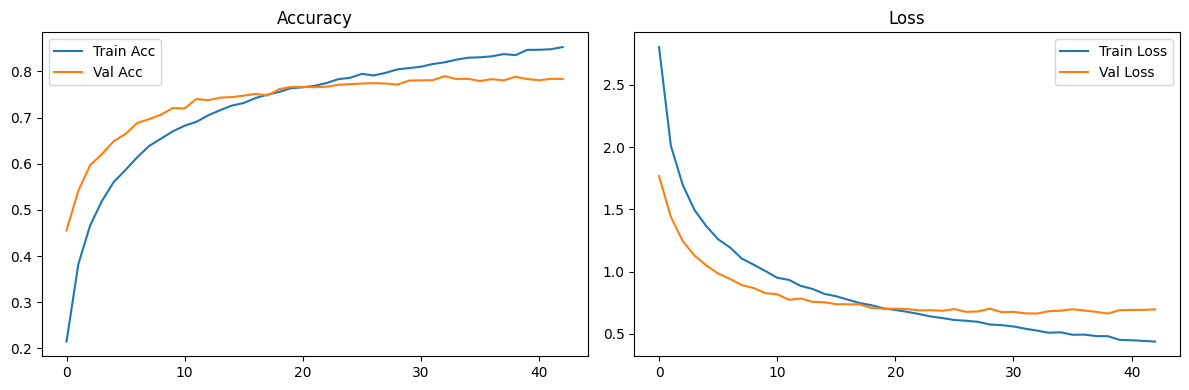


=== 验证集评估 ===
混淆矩阵已保存: F:/DataSet/Raw_Skeleton_S01-S17/result\confusion_matrix_20250927_104345.png
混淆矩阵已保存: F:/DataSet/Raw_Skeleton_S01-S17/result\confusion_matrix_20250927_104345.png


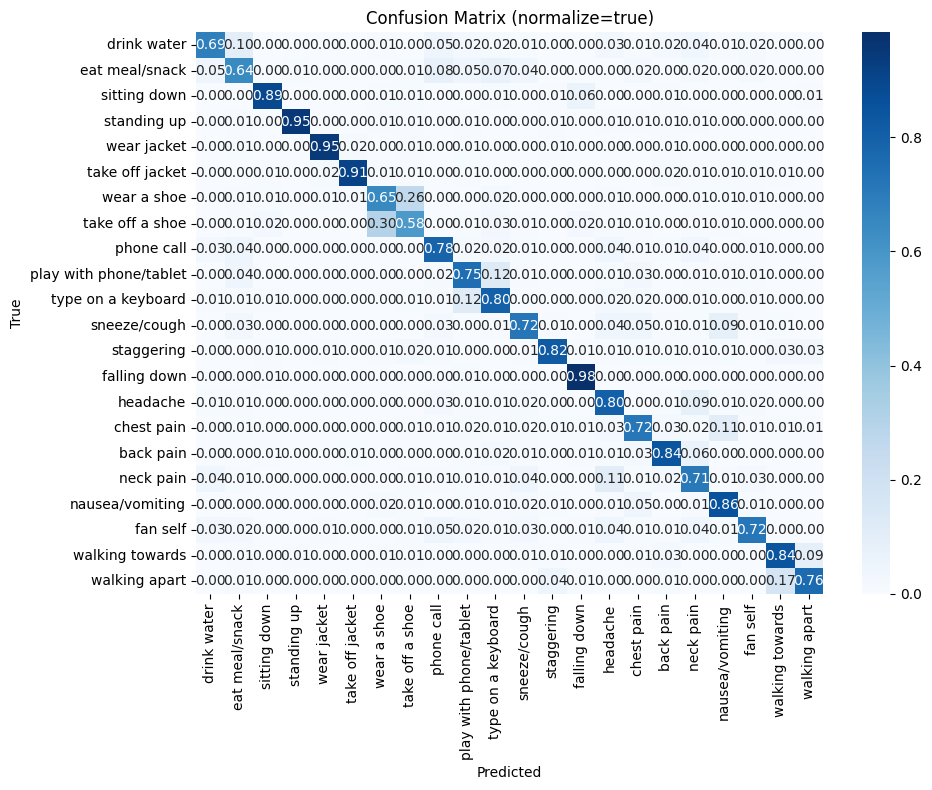

                        precision    recall  f1-score   support

           drink water     0.8089    0.6865    0.7427       185
        eat meal/snack     0.6761    0.6432    0.6593       185
          sitting down     0.9326    0.8925    0.9121       186
           standing up     0.9831    0.9511    0.9669       184
           wear jacket     0.9617    0.9462    0.9539       186
       take off jacket     0.9659    0.9140    0.9392       186
           wear a shoe     0.6452    0.6486    0.6469       185
       take off a shoe     0.6136    0.5838    0.5983       185
            phone call     0.7411    0.7849    0.7624       186
play with phone/tablet     0.6970    0.7459    0.7206       185
    type on a keyboard     0.6916    0.7957    0.7400       186
          sneeze/cough     0.7791    0.7204    0.7486       186
            staggering     0.9000    0.8226    0.8596       186
          falling down     0.8927    0.9839    0.9361       186
              headache     0.6930    0.

In [16]:
# 统一入口：使用全局 TRAIN_* 配置进行一键训练 + 评估 + 自动保存
# 运行整本 Notebook 后无需手动再调用，如 AUTO_RUN_AFTER_DEFINE=True 会自动执行

def train_with_global_config(normalize='true', pretrained_path='ntu_action_subset_model.keras', autorun_print_only=False):
    start_time = datetime.now()
    print("==== 开始训练流程 ====")
    sequences, labels = step1_load_and_filter()
    processed_sequences, labels = step2_preprocess_and_cache(sequences, labels)
    remapped_labels, label_to_new, new_to_label, unique_labels = step3_label_remap(labels)
    model, X_train, X_val, y_train, y_val = step4_build_model_and_split(processed_sequences, remapped_labels, unique_labels)
    history = step5_train_and_save(
        model, X_train, y_train, X_val, y_val,
        label_to_new, new_to_label, unique_labels,
        pretrained_path=pretrained_path,
        epochs=TRAIN_EPOCHS,
        batch_size=TRAIN_BATCH_SIZE,
        learning_rate=TRAIN_LR,
        optimizer=TRAIN_OPTIMIZER,
        use_optimized=USE_OPTIMIZED_MODEL
    )
    step6_plot_history(history, save=True)
    print('\n=== 验证集评估 ===')
    evaluate_model_confusion_report(model, X_val, y_val, new_to_label, action_name_map=ACTION_NAME_MAP, normalize=normalize)
    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()
    meta = {
        'start_time': start_time.strftime('%Y-%m-%d %H:%M:%S'),
        'end_time': end_time.strftime('%Y-%m-%d %H:%M:%S'),
        'duration_sec': duration,
        'epochs': TRAIN_EPOCHS,
        'batch_size': TRAIN_BATCH_SIZE,
        'learning_rate': TRAIN_LR,
        'optimizer': TRAIN_OPTIMIZER,
        'use_optimized_model': USE_OPTIMIZED_MODEL,
        'selected_actions': SELECTED_ACTIONS,
        'model_path': pretrained_path
    }
    meta_path = os.path.join(REPORT_DIR, f"training_meta_{end_time.strftime('%Y%m%d_%H%M%S')}.json")
    with open(meta_path, 'w', encoding='utf-8') as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)
    print("训练元数据已保存:", meta_path)
    return model, history

print("统一入口 train_with_global_config() 已就绪 (含自动保存与元数据记录)。")

# 自动触发
if 'AUTO_RUN_AFTER_DEFINE' in globals() and AUTO_RUN_AFTER_DEFINE:
    try:
        print("检测到 AUTO_RUN_AFTER_DEFINE=True, 自动启动训练...")
        _model, _history = train_with_global_config(normalize='true')
    except Exception as e:
        print("自动训练失败:", e)

In [17]:
# 评估工具：混淆矩阵 + 分类报告（自动保存报告）
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model_confusion_report(model_obj, X_val, y_val, new_to_label, action_name_map=None, normalize='true', figsize=(10,8), save_report=True, report_prefix="classification_report"):
    X_val_scaled = model_obj.scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    probs = model_obj.model.predict(X_val_scaled, verbose=0)
    y_pred_new = np.argmax(probs, axis=1)
    y_true_old = np.array([new_to_label[int(n)] for n in y_val])
    y_pred_old = np.array([new_to_label[int(n)] for n in y_pred_new])
    new_ids_sorted = sorted(new_to_label.keys())
    old_ids_sorted = [new_to_label[n] for n in new_ids_sorted]
    cm = confusion_matrix(y_true_old, y_pred_old, labels=old_ids_sorted)
    cm_display = cm.astype('float')
    if normalize == 'true':
        row_sums = cm_display.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1
        cm_display = cm_display / row_sums
    elif normalize == 'pred':
        col_sums = cm_display.sum(axis=0, keepdims=True)
        col_sums[col_sums == 0] = 1
        cm_display = cm_display / col_sums
    elif normalize == 'all':
        total = cm_display.sum()
        if total > 0:
            cm_display = cm_display / total
    if action_name_map is None:
        label_names = [f"A{oid}" for oid in old_ids_sorted]
    else:
        label_names = [action_name_map.get(oid, f"A{oid}") for oid in old_ids_sorted]
    plt.figure(figsize=figsize)
    sns.heatmap(cm_display, annot=cm.shape[0] <= 30, fmt='.2f' if normalize else 'd',
                xticklabels=label_names, yticklabels=label_names, cmap='Blues')
    title_suffix = '' if not normalize else f' (normalize={normalize})'
    plt.title('Confusion Matrix' + title_suffix)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    cm_path = os.path.join(RESULT_DIR, f"confusion_matrix_{timestamp}.png")
    plt.savefig(cm_path, dpi=150)
    print("混淆矩阵已保存:", cm_path)
    plt.show()
    if action_name_map is not None:
        target_names = [action_name_map.get(oid, f"A{oid}") for oid in old_ids_sorted]
        report_text = classification_report(y_true_old, y_pred_old, labels=old_ids_sorted, target_names=target_names, digits=4)
    else:
        report_text = classification_report(y_true_old, y_pred_old, labels=old_ids_sorted, digits=4)
    print(report_text)
    if save_report:
        report_ts = datetime.now().strftime('%Y%m%d_%H%M%S')
        report_path = os.path.join(REPORT_DIR, f"{report_prefix}_{report_ts}.txt")
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write("# 分类报告\n")
            f.write(report_text + "\n\n")
            f.write("# 类别顺序 (old ids):\n")
            f.write(','.join(map(str, old_ids_sorted)) + "\n")
        print("分类报告已保存:", report_path)
    return y_true_old, y_pred_old, cm

print("评估函数 evaluate_model_confusion_report() 已更新：含混淆矩阵与分类报告自动保存。")

评估函数 evaluate_model_confusion_report() 已更新：含混淆矩阵与分类报告自动保存。
